In [1]:
import sys
import os
# Add the RQ1 directory to the path
# sys.path.append(os.path.abspath("../"))
from patchscope import PatchScope

model_name = "google/gemma-3-12b-it"
# model_name = "google/gemma-3-12b-pt"
# model_name = "meta-llama/Llama-2-7b-chat-hf"
# model_name = "Tower-Babel/Babel-9B-Chat"
word_nonword_cls = PatchScope("English", model_name) # language is not used in the model name, but it is required by the class

Using device: cuda


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

## anisotropy

In [3]:
import numpy as np
import torch
import torch.nn.functional as F


def cos_contrib(emb1, emb2):
    """Cosine contribution per dimension"""
    numerator_terms = emb1 * emb2
    denom = torch.norm(emb1) * torch.norm(emb2)
    return (numerator_terms / denom).numpy()


def compute_crosslingual_anisotropy(hidden_en, hidden_ko, sample_size=5000, pair="aligned"):
    results = {}

    for layer in hidden_en:
        en_vecs = hidden_en[layer]
        ko_vecs = hidden_ko[layer]

        n = en_vecs.shape[0]
        dim = en_vecs.shape[1]
        if pair=="aligned":
            contribs = []
            for i in range(n):
                emb1 = en_vecs[i]
                emb2 = ko_vecs[i]
                contribs.append(cos_contrib(emb1, emb2))  # shape: (D,)
                    
        elif pair=="random":
            # Sample random pairs (not necessarily aligned)
            idx_pairs = [(np.random.randint(0, n), np.random.randint(0, n)) for _ in range(sample_size)]

            contribs = []
            for i, j in idx_pairs:
                emb1 = en_vecs[i]
                emb2 = ko_vecs[j]
                contribs.append(cos_contrib(emb1, emb2))  # (D,)

        contribs = np.stack(contribs)  # (sample_size, D)
        mean_contrib = contribs.mean(axis=0)  # (D,)
        anisotropy = mean_contrib.sum()

        results[layer] = {
            "anisotropy": anisotropy,
            "mean_contrib": mean_contrib,
            "top_dims": np.flip(np.argsort(mean_contrib)[-10:])
        }

    return results

import matplotlib.pyplot as plt
def plot_anisotropy(results, model_name, lang1, lang2):
    layers = list(results.keys())
    anisotropy_values = [results[l]["anisotropy"] for l in layers]

    plt.figure(figsize=(8, 4))
    plt.plot(layers, anisotropy_values, marker='o')
    plt.xlabel("Layer")
    plt.ylabel("Anisotropy")
    plt.title(f"Anisotropy across layers ({model_name} - {lang1}&{lang2})")
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"anisotropy_{model_name}_{lang1}&{lang2}.png")
    plt.show()


In [4]:
lang1 = "en"
lang2 = "ko"

model_name = "Tower-Babel/Babel-9B-Chat"
hidden_1 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_1.pt")
hidden_2 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_1.pt")
results_babel = compute_crosslingual_anisotropy(hidden_1, hidden_2)


model_name = "google/gemma-3-12b-it"
hidden_1 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_1.pt")
hidden_2 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_1.pt")
results_gemma = compute_crosslingual_anisotropy(hidden_1, hidden_2)


model_name = "meta-llama/Llama-2-7b-chat-hf"
hidden_1 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_1.pt")
hidden_2 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_1.pt")
results_llama = compute_crosslingual_anisotropy(hidden_1, hidden_2)

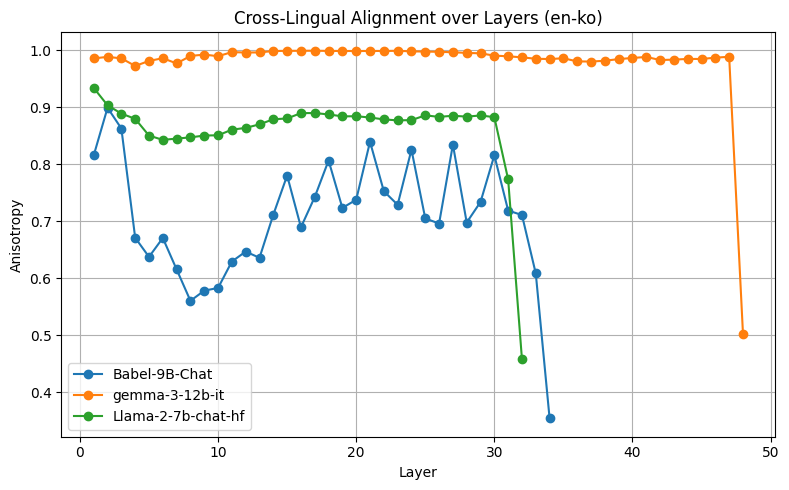

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Example: results_babel, results_gemma, results_llama
layers_babel = set(results_babel.keys())
layers_gemma = set(results_gemma.keys())
layers_llama = set(results_llama.keys())

# Union of all layers, sorted
all_layers = sorted(layers_babel | layers_gemma | layers_llama)

def get_acc(results, all_layers):
    # Return a list of values for all_layers, np.nan if missing
    return [results[l]['anisotropy'] if l in results else np.nan for l in all_layers]

acc_babel = get_acc(results_babel, all_layers)
acc_gemma = get_acc(results_gemma, all_layers)
acc_llama = get_acc(results_llama, all_layers)

plt.figure(figsize=(8, 5))
plt.plot(all_layers, acc_babel, label='Babel-9B-Chat', marker='o')
plt.plot(all_layers, acc_gemma, label='gemma-3-12b-it', marker='o')
plt.plot(all_layers, acc_llama, label='Llama-2-7b-chat-hf', marker='o')
plt.xlabel("Layer")
plt.ylabel("Anisotropy")
plt.title("Cross-Lingual Alignment over Layers (en-ko)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
def plot_top_dims(results, model_name, lang1, lang2):
    layers = list(results.keys())
    dims = len(results[layers[0]]["mean_contrib"])

    # Create a matrix: layers x dims
    contrib_matrix = np.stack([results[l]["mean_contrib"] for l in layers])

    top_k = 10
    top_dims = np.argsort(np.mean(contrib_matrix, axis=0))[-top_k:][::-1]

    plt.figure(figsize=(10, 5))
    for d in top_dims:
        plt.plot(layers, contrib_matrix[:, d], label=f"Dim {d}")

    plt.xlabel("Layer")
    plt.ylabel("Cosine Contribution")
    plt.title(f"Top-{top_k} Dim Contributions Across Layers ({model_name} - {lang1}↔{lang2})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"topdims_{model_name}_{lang1}_{lang2}.png")
    plt.show()


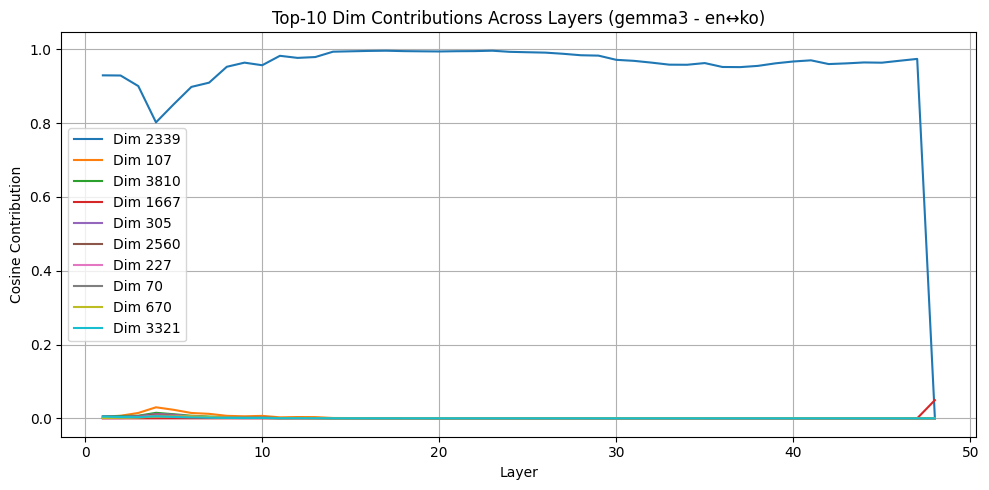

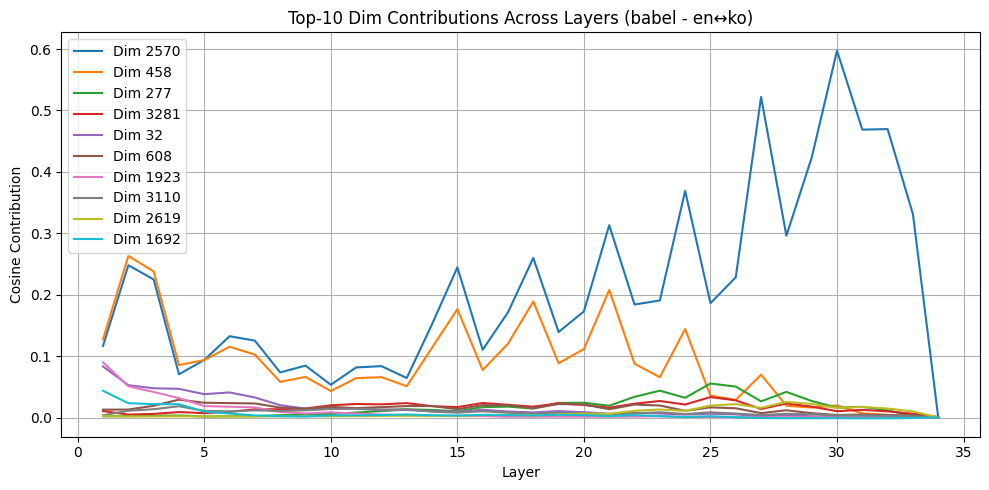

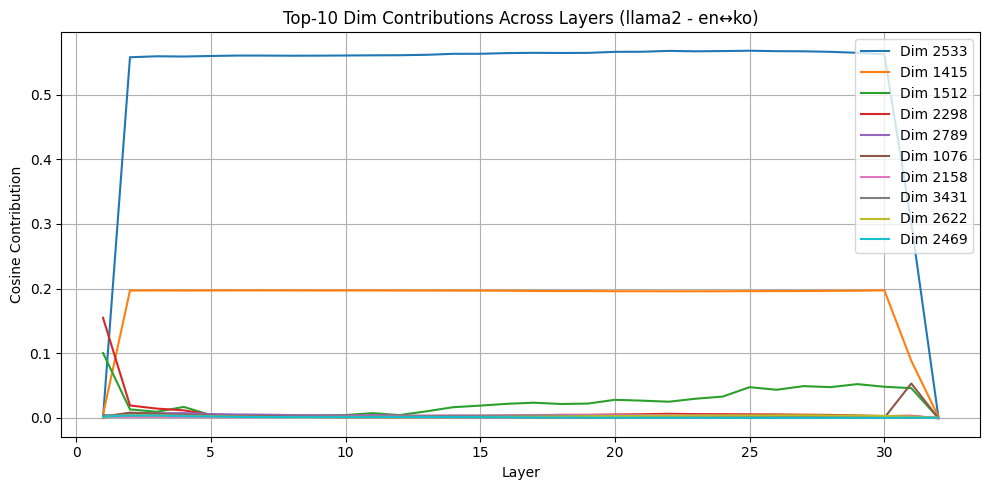

In [9]:
plot_top_dims(results_gemma, "gemma3", "en", "ko")
plot_top_dims(results_babel, "babel", "en", "ko")
plot_top_dims(results_llama, "llama2", "en", "ko")


In [ ]:

model_name = "meta-llama/Llama-2-7b-chat-hf"
hidden_1 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_1.pt")
hidden_2 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_1.pt")
results_llama = compute_crosslingual_anisotropy(hidden_1, hidden_2)

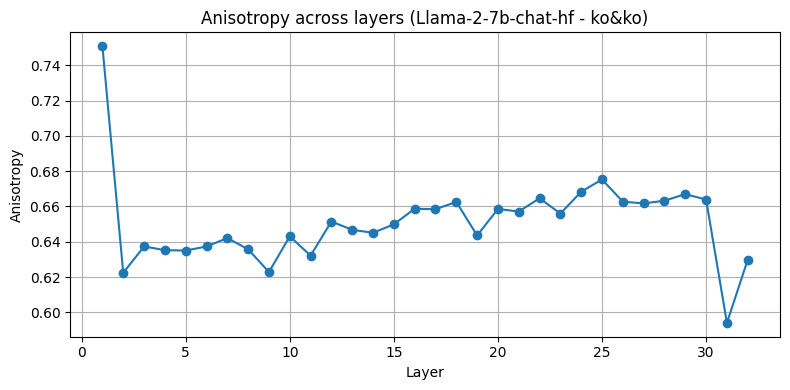

In [18]:
results = compute_crosslingual_anisotropy(hidden_2, hidden_2,pair="random")
plot_anisotropy(results, model_name=model_name.split("/")[-1], lang1="ko", lang2="ko")

## cross-lingual alignment

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def prepare_dataset(lang1, lang2):
    dataset_en_ko = load_dataset("tatoeba", lang1=lang1, lang2=lang2)
    dataset_en_ko = dataset_en_ko['train'].to_pandas()
    dataset_en_ko[lang1] = dataset_en_ko['translation'].str[lang1]
    dataset_en_ko[lang2] = dataset_en_ko['translation'].str[lang2]
    dataset_en_ko = dataset_en_ko[[lang1, lang2]]
    dataset_en_ko = dataset_en_ko[dataset_en_ko[lang1].str.len() >= 3]
    dataset_en_ko = dataset_en_ko[dataset_en_ko[lang2].str.len() >= 3]
    dataset_en_ko = dataset_en_ko.sample(n=1000, random_state=2025).reset_index(drop=True)
    dataset_en_ko[f'{lang1}_tokens'] = dataset_en_ko[lang1].apply(word_nonword_cls.tokenizer.tokenize)
    dataset_en_ko[f'{lang2}_tokens'] = dataset_en_ko[lang2].apply(word_nonword_cls.tokenizer.tokenize)
    return dataset_en_ko

def compute_crosslingual_cosine(hidden_en, hidden_ko, top_k=5):
    results = {}

    for layer in hidden_en:
        en_vecs = hidden_en[layer]  # shape: (N, D)
        ko_vecs = hidden_ko[layer]  # shape: (N, D)

        # Normalize to unit vectors for cosine similarity
        en_norm = F.normalize(en_vecs, p=2, dim=1)  # (N, D)
        ko_norm = F.normalize(ko_vecs, p=2, dim=1)  # (N, D)

        # Compute cosine similarity: (N x D) @ (D x N) = (N x N)
        global sim_matrix
        sim_matrix = en_norm @ ko_norm.T  # (N, N)

        # For each English vector, get top-k most similar Korean vectors
        topk_values, topk_indices = torch.topk(sim_matrix, k=top_k, dim=1)  # (N, top_k)
        
        # Check if correct alignment exists in top-k (optional accuracy check)
        correct = torch.arange(sim_matrix.size(0)).to(topk_indices.device)
        hits = (topk_indices == correct.unsqueeze(1)).any(dim=1).float()  # 1 if correct in top-k

        results[layer] = {
            "similarity_matrix": sim_matrix,
            "topk_indices": topk_indices,
            "topk_values": topk_values,
            "topk_accuracy": hits.mean().item(),  # overall top-k accuracy
        }

    return results

Extracting hidden states: 100%|██████████| 1000/1000 [01:47<00:00,  9.29batch/s]


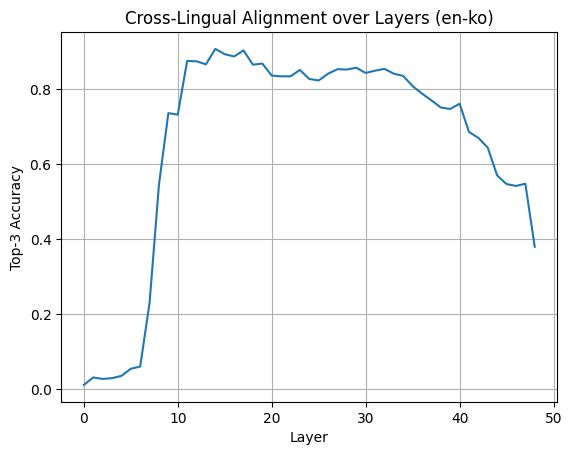

In [11]:
lang1 = "en"
lang2 = "ko"

dataset_en_ko = prepare_dataset(lang1, lang2)

hidden_1 = word_nonword_cls.extract_token_i_hidden_states_original(inputs = dataset_en_ko[f'{lang1}'].tolist(), tokenizer=word_nonword_cls.tokenizer, model=word_nonword_cls.model)
hidden_2 = word_nonword_cls.extract_token_i_hidden_states_original(inputs = dataset_en_ko[f'{lang2}'].tolist(), tokenizer=word_nonword_cls.tokenizer, model=word_nonword_cls.model)
torch.save(hidden_1, f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_2.pt")
torch.save(hidden_2, f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_2.pt")

top_k = 3
results = compute_crosslingual_cosine(hidden_1, hidden_2, top_k=top_k)

layers = sorted(results.keys())
accuracies = [results[l]['topk_accuracy'] for l in layers]
plt.plot(layers, accuracies)
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Accuracy")
plt.title(f"Cross-Lingual Alignment over Layers ({lang1}-{lang2})")
plt.grid(True)
plt.show()

In [ ]:
hidden_1

{0: tensor([[-0.3915, -0.9493,  0.2184,  ..., -0.2175, -0.2326, -0.1976],
         [-0.3915, -0.9493,  0.2184,  ..., -0.2175, -0.2326, -0.1976],
         [-0.3915, -0.9493,  0.2184,  ..., -0.2175, -0.2326, -0.1976],
         ...,
         [-0.3915, -0.9493,  0.2184,  ..., -0.2175, -0.2326, -0.1976],
         [-0.3915, -0.9493,  0.2184,  ..., -0.2175, -0.2326, -0.1976],
         [-0.3915, -0.9493,  0.2184,  ..., -0.2175, -0.2326, -0.1976]]),
 1: tensor([[-0.3100, -0.1173, -5.4941,  ..., -0.0357, -0.4781,  0.0847],
         [-0.2981, -0.1695,  2.1681,  ..., -0.0149, -0.5527,  0.0114],
         [-0.2981, -0.2319, -6.0225,  ..., -0.0173, -0.4331,  0.1005],
         ...,
         [-0.3155, -0.2022, -2.8534,  ..., -0.0457, -0.4662,  0.0183],
         [-0.3062, -0.2232, -2.5716,  ..., -0.0324, -0.5767,  0.0168],
         [-0.2935, -0.2143, -1.4757,  ..., -0.0270, -0.4716,  0.0592]]),
 2: tensor([[-1.4216e-01,  2.2883e-01, -3.3889e+00,  ..., -1.4115e-01,
          -5.0699e-01,  8.4635e-02],
  

: 

In [17]:
for layer, v in hidden_1.items():
    print(torch.isnan(v).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [29]:
lang1 = "en"
lang2 = "ko"

# model_name = "google/gemma-3-12b-it"
# model_name = "Tower-Babel/Babel-9B-Chat"
model_name = "meta-llama/Llama-2-7b-chat-hf"

hidden_1 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang1}_1.pt")
hidden_2 = torch.load(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_{model_name.split("/")[-1]}_{lang2}_1.pt")

In [26]:
layer_hiddens = hidden_1[1]
layer_hiddens = F.normalize(layer_hiddens, p=2, dim=1)
layer_hiddens.shape

torch.Size([1000, 3584])

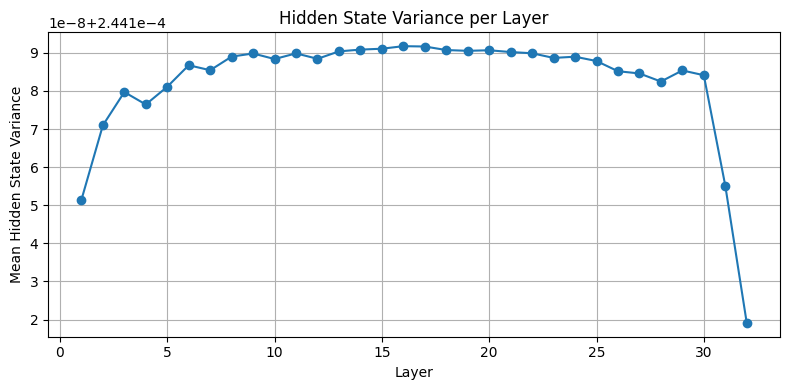

In [30]:
variances = []
for layer in hidden_1:
    layer_hiddens = hidden_1[layer]  # shape: (batch, hidden_dim)
    layer_hiddens = F.normalize(layer_hiddens, p=2, dim=1)
    var = layer_hiddens.var(dim=-1).mean().item()
    variances.append(var)
    
layers = sorted(hidden_1.keys())

plt.figure(figsize=(8, 4))
plt.plot(layers, variances, marker='o')
plt.xlabel("Layer")
plt.ylabel("Mean Hidden State Variance")
plt.title("Hidden State Variance per Layer")
plt.grid(True)
plt.tight_layout()
plt.show()

import pandas as pd
pd.Series(variances).to_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_variance_{model_name.split('/')[-1]}_{lang1}_1.csv", index=False)

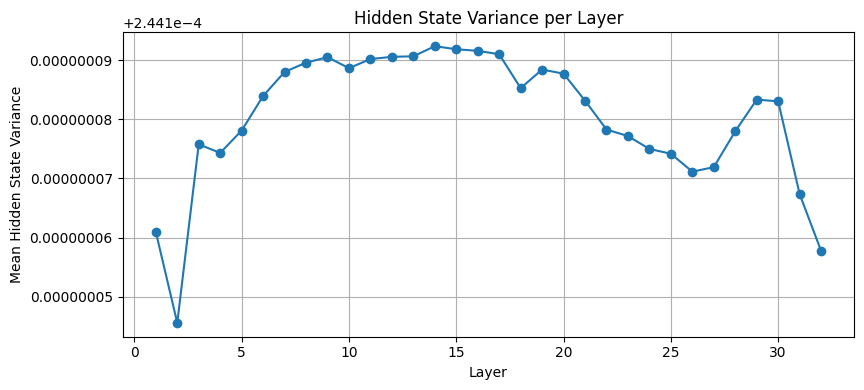

In [34]:
variances = []
for layer in hidden_2:
    layer_hiddens = hidden_2[layer]  # shape: (batch, hidden_dim)
    layer_hiddens = F.normalize(layer_hiddens, p=2, dim=1)

    var = layer_hiddens.var(dim=-1).mean().item()
    variances.append(var)
    
layers = sorted(hidden_2.keys())

plt.figure(figsize=(8, 4))
plt.plot(layers, variances, marker='o')
plt.xlabel("Layer")
plt.ylabel("Mean Hidden State Variance")
plt.title("Hidden State Variance per Layer")
plt.grid(True)
plt.tight_layout()
plt.ticklabel_format(style='plain', axis='y')  # <-- Add this line
plt.show()

import pandas as pd
pd.Series(variances).to_csv(f"/home/hyujang/multilingual-inner-lexicon/data/RQ1/TatoebaHiddens/hidden_variance_{model_name.split('/')[-1]}_{lang2}_1.csv", index=False)

Extracting hidden states: 100%|██████████| 1000/1000 [01:53<00:00,  8.81it/s]


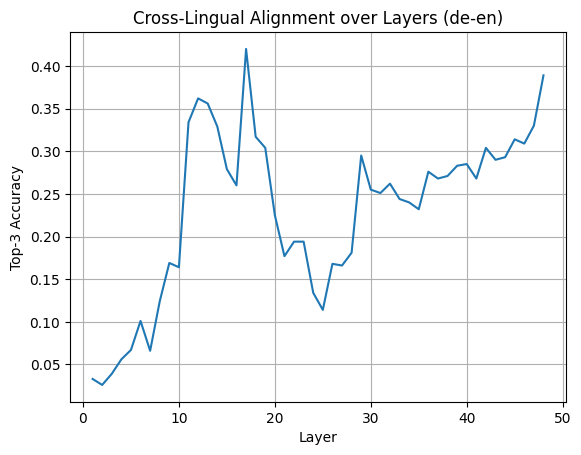

In [4]:
lang1 = "de"
lang2 = "en"

dataset_de_en = prepare_dataset(lang1, lang2)

hidden_1 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_en[f'{lang1}_tokens'].tolist())
hidden_2 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_en[f'{lang2}_tokens'].tolist())

top_k = 3
results = compute_crosslingual_cosine(hidden_1, hidden_2, top_k=top_k)

layers = sorted(results.keys())
accuracies = [results[l]['topk_accuracy'] for l in layers]
plt.plot(layers, accuracies)
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Accuracy")
plt.title(f"Cross-Lingual Alignment over Layers ({lang1}-{lang2})")
plt.grid(True)
plt.show()

Extracting hidden states: 100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]


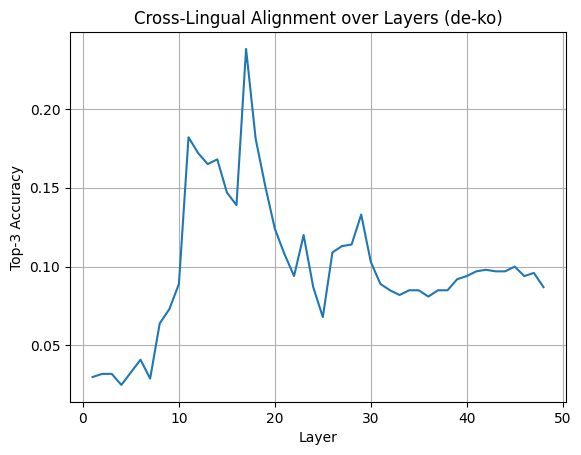

In [6]:
lang1 = "de"
lang2 = "ko"

dataset_de_ko = prepare_dataset(lang1, lang2)

hidden_1 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_ko[f'{lang1}_tokens'].tolist())
hidden_2 = word_nonword_cls.extract_token_i_hidden_states(dataset_de_ko[f'{lang2}_tokens'].tolist())

top_k = 3
results = compute_crosslingual_cosine(hidden_1, hidden_2, top_k=top_k)

layers = sorted(results.keys())
accuracies = [results[l]['topk_accuracy'] for l in layers]
plt.plot(layers, accuracies)
plt.xlabel("Layer")
plt.ylabel(f"Top-{top_k} Accuracy")
plt.title(f"Cross-Lingual Alignment over Layers ({lang1}-{lang2})")
plt.grid(True)
plt.show()